In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
import os

# Add parent directory to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.config import DATA_PATHS, PLOT_STYLE
from src.theme_analysis_lda import ThemeAnalyzerLDA

# Set plot style
plt.style.use(PLOT_STYLE)
sns.set_palette("viridis")

## 1. Topic Count Tuning (Coherence Scoring)

Before running the final LDA pipeline, we evaluate different `n_topics` values (2–10) for each bank using the **c_v coherence metric** (via gensim). Higher coherence = more semantically coherent topics.

**Run this section once** to identify the optimal `n_topics` per bank, then use those values in the `run_analysis()` call below.

In [2]:
# Step 1a: Load and preprocess data for coherence tuning
import nltk
nltk.download('punkt_tab', quiet=True)

analyzer = ThemeAnalyzerLDA(n_topics=5)

# Load data (reusing the analyzer's logic)
try:
    df_raw = pd.read_csv(DATA_PATHS.get('sentiment_results_twitter', DATA_PATHS['sentiment_results_twitter']))
except FileNotFoundError:
    df_raw = pd.read_csv(DATA_PATHS['processed_reviews'])

df_raw = df_raw.dropna(subset=['review_text'])

from tqdm import tqdm
tqdm.pandas(desc="Preprocessing for tuning")
df_raw['clean_text'] = df_raw['review_text'].progress_apply(analyzer.preprocess_text)
df_raw = df_raw[df_raw['clean_text'].str.len() > 0]

print(f"\nReady to tune. {len(df_raw)} reviews across {df_raw['bank_name'].nunique()} banks.")

Preprocessing for tuning: 100%|██████████| 9848/9848 [00:04<00:00, 2005.52it/s]



Ready to tune. 9405 reviews across 3 banks.


In [3]:
# Step 1b: Evaluate coherence for n_topics = 2..10 per bank
coherence_results = analyzer.find_optimal_topics(df_raw, topic_range=range(2, 11))


  Tuning n_topics for: Abyssinia Bank
  n_topics= 2  →  coherence (c_v) = 0.4231
  n_topics= 3  →  coherence (c_v) = 0.3659
  n_topics= 4  →  coherence (c_v) = 0.4016
  n_topics= 5  →  coherence (c_v) = 0.4455
  n_topics= 6  →  coherence (c_v) = 0.4414
  n_topics= 7  →  coherence (c_v) = 0.4304
  n_topics= 8  →  coherence (c_v) = 0.4802
  n_topics= 9  →  coherence (c_v) = 0.4314
  n_topics=10  →  coherence (c_v) = 0.4699
  ➤ Best n_topics for Abyssinia Bank: 8 (c_v = 0.4802)

  Tuning n_topics for: Commercial Bank of Ethiopia
  n_topics= 2  →  coherence (c_v) = 0.4525
  n_topics= 3  →  coherence (c_v) = 0.4989
  n_topics= 4  →  coherence (c_v) = 0.4821
  n_topics= 5  →  coherence (c_v) = 0.5158
  n_topics= 6  →  coherence (c_v) = 0.4413
  n_topics= 7  →  coherence (c_v) = 0.4476
  n_topics= 8  →  coherence (c_v) = 0.4994
  n_topics= 9  →  coherence (c_v) = 0.4797
  n_topics=10  →  coherence (c_v) = 0.4878
  ➤ Best n_topics for Commercial Bank of Ethiopia: 5 (c_v = 0.5158)

  Tuning n_

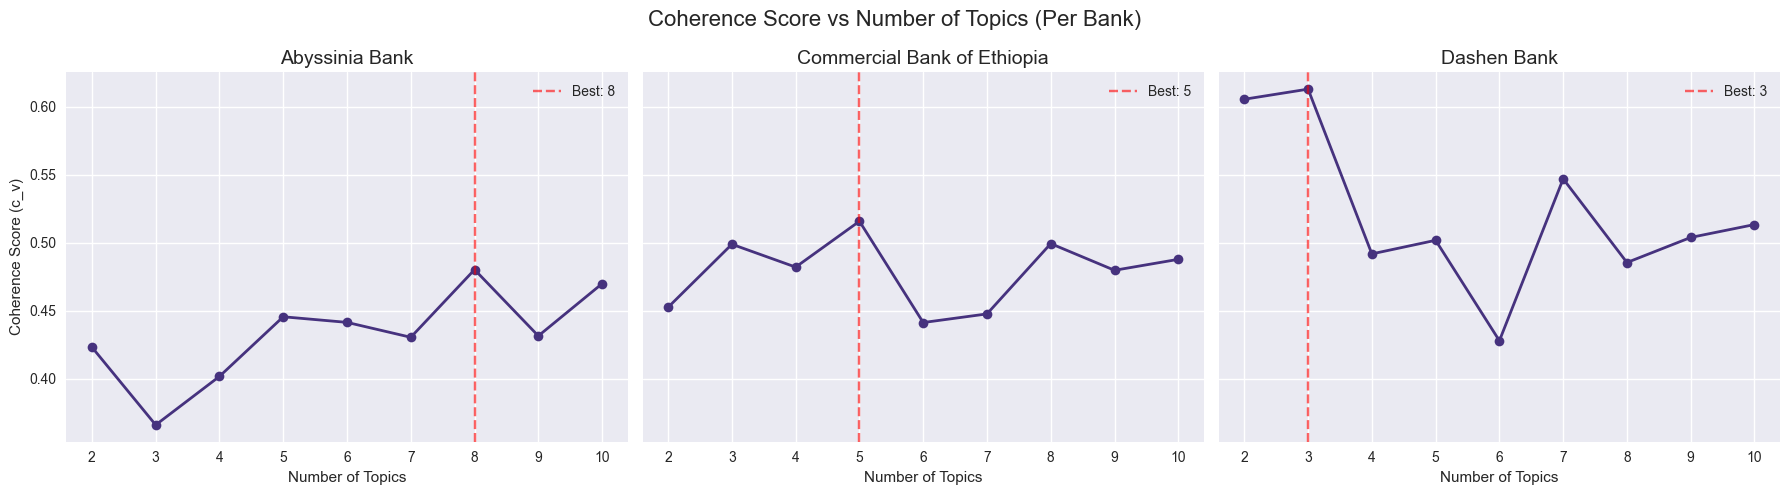

In [4]:
# Step 1c: Plot coherence vs n_topics per bank
fig, axes = plt.subplots(1, len(coherence_results), figsize=(6 * len(coherence_results), 5), sharey=True)

if len(coherence_results) == 1:
    axes = [axes]

for idx, (bank, scores) in enumerate(coherence_results.items()):
    ax = axes[idx]
    topics = sorted(scores.keys())
    coherences = [scores[t] for t in topics]
    ax.plot(topics, coherences, marker='o', linewidth=2)
    ax.set_title(f'{bank}', fontsize=14)
    ax.set_xlabel('Number of Topics')
    if idx == 0:
        ax.set_ylabel('Coherence Score (c_v)')
    ax.set_xticks(topics)
    # Mark the best point
    best_n = max(scores, key=scores.get)
    ax.axvline(x=best_n, color='red', linestyle='--', alpha=0.6, label=f'Best: {best_n}')
    ax.legend()

plt.suptitle('Coherence Score vs Number of Topics (Per Bank)', fontsize=16)
plt.tight_layout()
plt.show()

## 2. Run LDA Pipeline (Per Bank)

Based on the coherence plots above, choose the optimal `n_topics` for each bank. If a bank's coherence plot doesn't show a clear peak, default to 5.

**Update the `n_topics_per_bank` dictionary below** with your chosen values, then run.

In [2]:
# UPDATE THESE based on the coherence plots above
n_topics_per_bank = {
    'Commercial Bank of Ethiopia': 5,
    'Abyssinia Bank': 8,
    'Dashen Bank': 3,
}

analyzer = ThemeAnalyzerLDA(n_topics=5)
df = analyzer.run_analysis(n_topics_per_bank=n_topics_per_bank)

Loading data...
Preprocessing 9848 reviews (POS-aware Lemmatization)...


Preprocessing: 100%|██████████| 9848/9848 [00:08<00:00, 1185.98it/s]



  Preprocessing summary:
    Before: 9848 reviews
    After:  9405 reviews (443 dropped as empty)
    Abyssinia Bank: 1087 reviews
    Commercial Bank of Ethiopia: 7599 reviews
    Dashen Bank: 719 reviews

  LDA for Abyssinia Bank  (1087 reviews, 8 topics)
  Topic 0: bad, ever, great, application, worst, worst ever, error, every, worest, time
  Topic 1: excellent, download, apollo, awesome, could, cool, crash, financial, apollo account, excellent service
  Topic 2: work, developer, open, update, option, need, service, developer option, always, fix
  Topic 3: otp, allow, account, network, birr, manually, code, phone, number, abroad
  Topic 4: good, fast, new, version, user, simple, old, update, transfer, difficult
  Topic 5: best, nice, make, transaction, boa, system, bad, cbe, apps, call
  Topic 6: easy, wow, properly, amaze, android, work properly, available, apk, phone, late
  Topic 7: work, boa, time, like, crash, update, fix, well, take, day

  LDA for Commercial Bank of Ethiopia

## 3. Confidence Distribution Exploration

Each review has a `topic_confidence` score — the probability of the dominant topic. Higher confidence = the model is more certain about the assignment. Let's explore these distributions.

In [3]:
# Summary stats per bank per topic
confidence_stats = df.groupby(['bank_name', 'topic_id'])['topic_confidence'].describe()
print(confidence_stats.to_string())

                                       count      mean       std       min       25%       50%       75%       max
bank_name                   topic_id                                                                              
Abyssinia Bank              0          204.0  0.428418  0.280711  0.125000  0.125000  0.524624  0.682366  0.958315
                            1           42.0  0.583461  0.107130  0.375009  0.562500  0.562500  0.582616  0.854071
                            2          204.0  0.648138  0.160426  0.305404  0.562408  0.584526  0.781160  0.966336
                            3           29.0  0.596403  0.178832  0.374997  0.495968  0.562500  0.675519  0.941654
                            4          190.0  0.580114  0.100804  0.340788  0.562500  0.562500  0.562500  0.953898
                            5          135.0  0.596650  0.110438  0.281322  0.562500  0.562500  0.590742  0.937416
                            6           58.0  0.552033  0.139809  0.281272  0.52

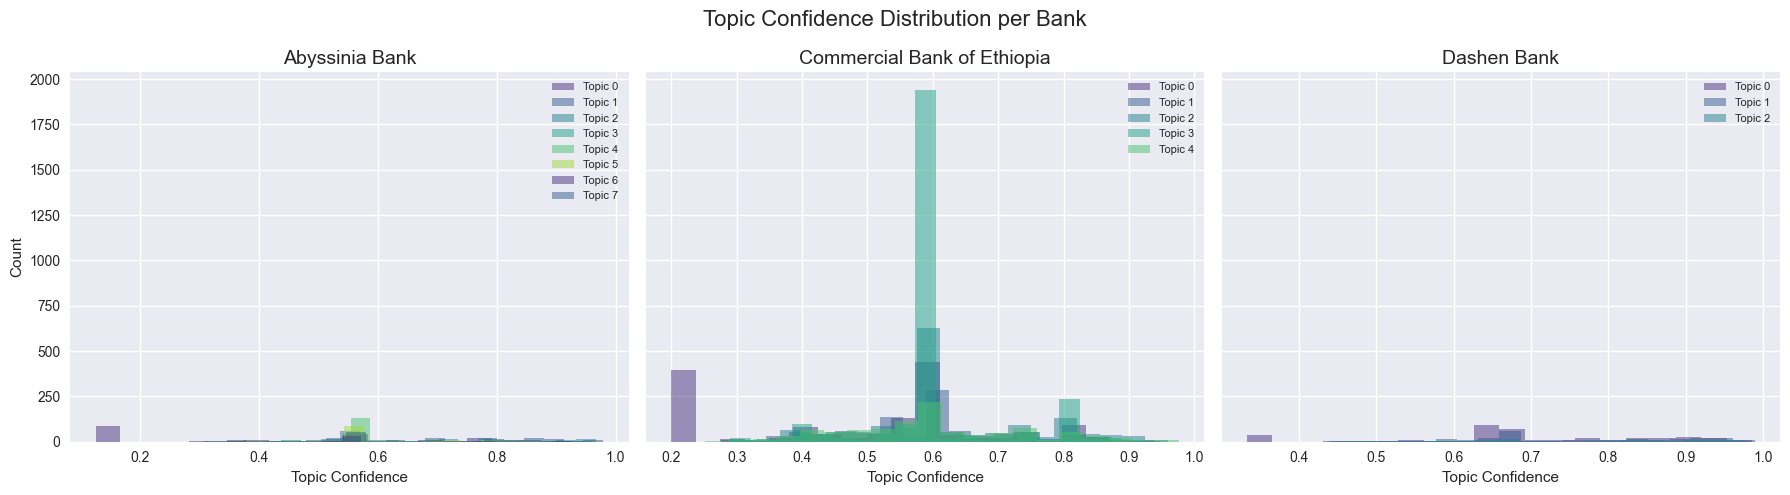

In [4]:
# Histogram of topic_confidence per bank (subplots)
banks = df['bank_name'].unique()
fig, axes = plt.subplots(1, len(banks), figsize=(6 * len(banks), 5), sharey=True)

if len(banks) == 1:
    axes = [axes]

for idx, bank in enumerate(banks):
    ax = axes[idx]
    bank_data = df[df['bank_name'] == bank]
    for topic_id in sorted(bank_data['topic_id'].unique()):
        topic_data = bank_data[bank_data['topic_id'] == topic_id]
        ax.hist(topic_data['topic_confidence'], bins=20, alpha=0.5, label=f'Topic {topic_id}')
    ax.set_title(f'{bank}', fontsize=14)
    ax.set_xlabel('Topic Confidence')
    if idx == 0:
        ax.set_ylabel('Count')
    ax.legend(fontsize=8)

plt.suptitle('Topic Confidence Distribution per Bank', fontsize=16)
plt.tight_layout()
plt.show()

## 4. High-Confidence Sample Review Reading

For each bank × topic combination, we show the **10 reviews with highest confidence**. This is the primary tool for manually interpreting what each topic is about.

Read the review text carefully and identify the common theme — this will guide topic naming in the next step.

In [10]:
# Show top-5 highest-confidence reviews per bank × topic
for bank in sorted(df['bank_name'].unique()):
    print(f"\n{'='*80}")
    print(f"  BANK: {bank}")
    print(f"{'='*80}")
    bank_data = df[df['bank_name'] == bank]
    for topic_id in sorted(bank_data['topic_id'].unique()):
        topic_data = bank_data[bank_data['topic_id'] == topic_id].nlargest(10, 'topic_confidence')
        print(f"\n  --- Topic {topic_id} (identified_topic: {topic_data.iloc[0]['identified_topic']}) ---")
        for i, (_, row) in enumerate(topic_data.iterrows(), 1):
            conf = row['topic_confidence']
            text = row['review_text'][:200]  # First 200 chars
            print(f"    [{i}] (conf={conf:.3f}) {text}")
        print()


  BANK: Abyssinia Bank

  --- Topic 0 (identified_topic: Abyssinia Bank_Topic_0) ---
    [1] (conf=0.958) please fix the bug this app does not work, it says Error The request was not successful. Please check device connectivity or try again.
    [2] (conf=0.942) Dear BOA, Are you sure you are upgrading your application. It is becoming worse and worse. Please fix the bug as quickly as possible.
    [3] (conf=0.912) it crush every time you opend it it is hard to pay quickly or to access
    [4] (conf=0.891) the worst bank ever. slow don't accept dual sim. they are very stupid and greedy
    [5] (conf=0.875) Ultimately, the worst mobile banking experience ever left me feeling exasperated and disillusioned.Its a nightmare
    [6] (conf=0.875) The dirtiest application ever seen...
    [7] (conf=0.875) worst banking app i have ever used. Try to modify it
    [8] (conf=0.875) The worst banking app ever. Never works!
    [9] (conf=0.854) The Worst application ever
    [10] (conf=0.854) Worst 

# High-Confidence Sample Review Reading Intrepretation

# Abyssinia Bank 
### Topic 0 and 1 are generic - they complain about the app just crashing when you open it .
### Topic 2 - developer options complaint - people are complaining that it keeps asking users to turn off developer options while it is not enabled
### Topic 3 - OTP enetring manually should be allowed users are complaining it doesn't automatially allow entering of otp
### Topic 4-  NOT user friendly makes it hard to use - UI needs to be freiendly, approachable
### Topic 5 comparison to CBE - users complain it is bad and that tehy need learn from cbe .Users want the features from CBE.
### Topic 6 - Mixed 
### Topic 7-  frequent crashing!!

# CBE bank
## Topic 0-
## Topic 1- RECENT transactions not shwoing this also overlaps with topic 2 - time of transcation not shown, no old transactions,    veey vague 
## Topic 2- NEW UPDATE runined things - crashing and closing this topic also shows complaints about trasactions hsitory not showing like topic 1
## Topic 3 - very vague praise for being the best 
## Topic 4- Recent update makes  the interafce  is not liked by users they hate the pin input it is hard , pin keyboard won't dropdown- the numpad design is bad and needs to be reverted.


# Dashen Bank
## Topic 0- general praise fo being smooth this topic is highly positice as the setiment scores show below - praised for being easy to use , fast- selling point is "all you need " in one app! 
## Topic 1 - User Interface -- ui is being praised and Transaction mosstly  issues  like freezing crashing when making transsctions, fialiing to send to teleberr an dother banks, but some positive salso 
## Topic 2 -  Reseting pin , otp pin , security issues, no 2fa, dveloper mode problems to turn of 


## It seems across all banks the dvdeloper options issue is a unified theme across all!

# Based on my analysis the topics can be named and further themes can be extracted per topic .


## 5. Topic Naming

Based on the keywords printed during `run_analysis()` and the high-confidence sample reviews above, manually assign descriptive names to each bank × topic combination.

**Update the `topic_labels` dictionary below**, then run the cell to:
1. Map the labels onto the dataframe
2. Re-save the CSV with named topics

In [ ]:
topic_labels = {
    # --- Commercial Bank of Ethiopia ---
    'Commercial Bank of Ethiopia_Topic_0': 'General Praise & Ease of Use',
    'Commercial Bank of Ethiopia_Topic_1': 'Transaction History & Account Access',
    'Commercial Bank of Ethiopia_Topic_2': 'Update-Induced Crashes & Sync Issues',
    'Commercial Bank of Ethiopia_Topic_3': 'General Satisfaction & Praise',
    'Commercial Bank of Ethiopia_Topic_4': 'Numpad/UI Redesign After Update',
    # --- Abyssinia Bank ---
    'Abyssinia Bank_Topic_0': 'App Errors & Poor Experience',
    'Abyssinia Bank_Topic_1': 'App Crashes & Instability',
    'Abyssinia Bank_Topic_2': 'Developer Options Blocking',
    'Abyssinia Bank_Topic_3': 'OTP Input & Diaspora Access',
    'Abyssinia Bank_Topic_4': 'UI/UX Design & Usability',
    'Abyssinia Bank_Topic_5': 'Competitor Comparison (CBE)',
    'Abyssinia Bank_Topic_6': 'General Mixed (Noise)',
    'Abyssinia Bank_Topic_7': 'Frequent Crashes & Feature Failures',
    # --- Dashen Bank ---
    'Dashen Bank_Topic_0': 'Brand Praise & Overall Experience',
    'Dashen Bank_Topic_1': 'Transactions & App Functionality',
    'Dashen Bank_Topic_2': 'Security, Authentication & Developer Options',
}

# ---------------------------------------------------------
# THEMES — one topic can map to multiple themes (semicolon-separated)
# These come from the pain points & drivers analysis
# ---------------------------------------------------------
theme_mapping = {
    # --- Abyssinia Bank ---
    'Abyssinia Bank_Topic_0': 'App Stability & Crashes',
    'Abyssinia Bank_Topic_1': 'App Stability & Crashes',
    'Abyssinia Bank_Topic_2': 'Developer Options Blocking',
    'Abyssinia Bank_Topic_3': 'OTP Input & Diaspora Access',
    'Abyssinia Bank_Topic_4': 'UI/UX Design & Usability',
    'Abyssinia Bank_Topic_5': 'Competitor Comparison (CBE)',
    'Abyssinia Bank_Topic_6': 'General Mixed',
    'Abyssinia Bank_Topic_7': 'App Stability & Crashes',
    # --- Commercial Bank of Ethiopia ---
    'Commercial Bank of Ethiopia_Topic_0': 'User Satisfaction & Ease of Use',
    'Commercial Bank of Ethiopia_Topic_1': 'Transaction History & Account Access',
    'Commercial Bank of Ethiopia_Topic_2': 'Update-Induced App Instability',
    'Commercial Bank of Ethiopia_Topic_3': 'User Satisfaction & Ease of Use',
    'Commercial Bank of Ethiopia_Topic_4': 'Numpad/UI Redesign Issues',
    # --- Dashen Bank (multi-themed topics) ---
    'Dashen Bank_Topic_0': 'All-in-One Super App Experience; Speed & Reliability',
    'Dashen Bank_Topic_1': 'Transaction Failures & Freezing; Modern UI/UX Design',
    'Dashen Bank_Topic_2': 'Security & Authentication Gaps; Developer Options Blocking',
}

# Apply themes first (using original topic IDs), then labels
df['theme'] = df['identified_topic'].map(theme_mapping).fillna('Other')
df['identified_topic'] = df['identified_topic'].map(topic_labels).fillna(df['identified_topic'])

# Re-save
output_path = DATA_PATHS['theme_results_lda']
df.to_csv(output_path, index=False)
print(f"✅ Named topics + themes saved to: {output_path}")
print(f"\nSample:")
print(df[['bank_name', 'identified_topic', 'theme', 'topic_confidence']].head(15).to_string())
print(f"\nThemes per bank:")
print(df.groupby(['bank_name', 'theme']).size().to_string())

✅ Named topics + themes saved to: ../data/processed/reviews_with_themes_lda.csv

Sample:
         bank_name                     identified_topic                        theme  topic_confidence
0   Abyssinia Bank         App Errors & Poor Experience      App Stability & Crashes          0.912466
1   Abyssinia Bank          Competitor Comparison (CBE)  Competitor Comparison (CBE)          0.562500
2   Abyssinia Bank  Frequent Crashes & Feature Failures      App Stability & Crashes          0.927058
3   Abyssinia Bank           Developer Options Blocking   Developer Options Blocking          0.708303
4   Abyssinia Bank             UI/UX Design & Usability     UI/UX Design & Usability          0.562500
5   Abyssinia Bank  Frequent Crashes & Feature Failures      App Stability & Crashes          0.824917
6   Abyssinia Bank             UI/UX Design & Usability     UI/UX Design & Usability          0.562500
7   Abyssinia Bank             UI/UX Design & Usability     UI/UX Design & Usability   

## 6. Per-Bank TF-IDF Keyword Extraction (Validation)

As a validation step, we extract the top 20 TF-IDF keywords/bigrams per bank. These keywords can be used for:
- Confirming that LDA topics make sense
- Generating word clouds in Task 4

In [17]:
# Per-bank TF-IDF top keywords
for bank in sorted(df['bank_name'].unique()):
    bank_data = df[df['bank_name'] == bank]
    tfidf = TfidfVectorizer(max_features=20, ngram_range=(1, 2))
    try:
        tfidf.fit(bank_data['clean_text'])
        keywords = tfidf.get_feature_names_out()
        print(f"\n{bank} — Top 20 TF-IDF Keywords:")
        print(f"  {', '.join(keywords)}")
    except ValueError:
        print(f"\n{bank}: Not enough text data for TF-IDF.")


Abyssinia Bank — Top 20 TF-IDF Keywords:
  application, bad, best, boa, crash, developer, ever, fix, good, like, make, need, nice, open, option, service, time, transaction, update, work

Commercial Bank of Ethiopia — Top 20 TF-IDF Keywords:
  account, application, best, cbe, easy, fast, good, great, like, make, money, need, nice, service, time, transaction, transfer, update, well, work

Dashen Bank — Top 20 TF-IDF Keywords:
  application, best, dashen, dashen super, easy, experience, fast, feature, good, great, like, make, need, nice, super, time, transaction, use, user, work


## We can see that keywords are very generic across banks and could benefit from addditional stop word removal but since the thematic analysis is strong this is an optimization problem

# 7. Visualizations

## Theme Distribution Per Bank

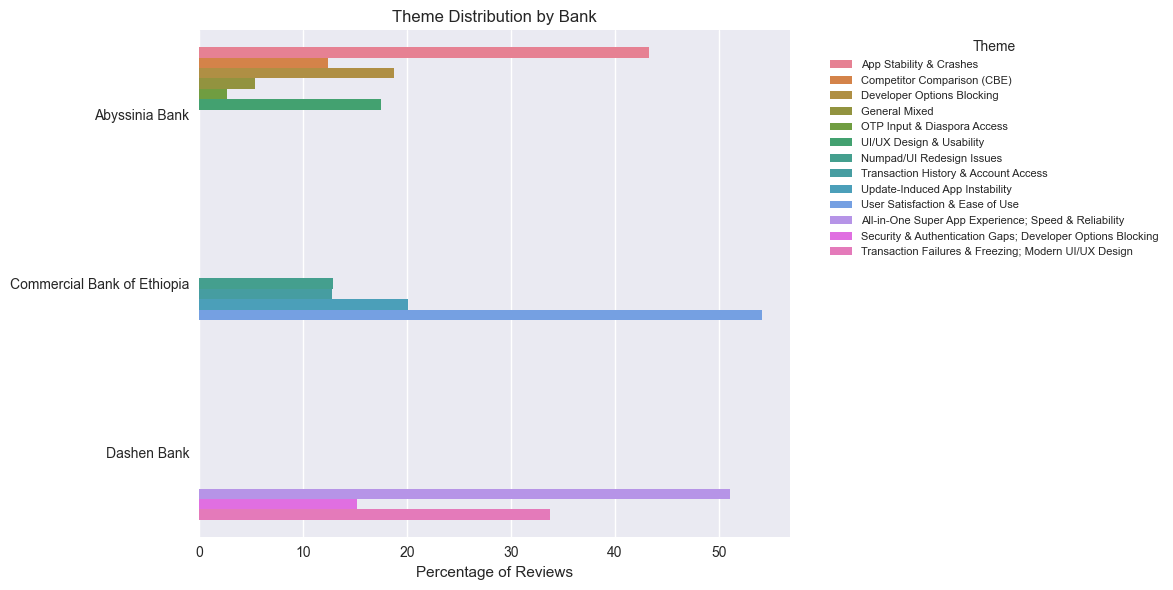

In [20]:
# # 7a. Topic distribution per bank (percentage)
# topic_by_bank = df.groupby(['bank_name', 'identified_topic']).size().reset_index(name='count')
# total_by_bank = df.groupby('bank_name').size().reset_index(name='total')
# topic_by_bank = topic_by_bank.merge(total_by_bank, on='bank_name')
# topic_by_bank['percentage'] = (topic_by_bank['count'] / topic_by_bank['total']) * 100

# plt.figure(figsize=(14, 8))
# sns.barplot(data=topic_by_bank, x='bank_name', y='percentage', hue='identified_topic')
# plt.title('Topic Distribution by Bank (Percentage)')
# plt.xlabel('Bank')
# plt.ylabel('Percentage of Reviews')
# plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()
# 7c. Theme distribution per bank (horizontal stacked bar)
theme_counts = df.groupby(['bank_name', 'theme']).size().reset_index(name='count')
total_by_bank = df.groupby('bank_name').size().reset_index(name='total')
theme_counts = theme_counts.merge(total_by_bank, on='bank_name')
theme_counts['percentage'] = (theme_counts['count'] / theme_counts['total']) * 100
plt.figure(figsize=(12, 6))
sns.barplot(data=theme_counts, y='bank_name', x='percentage', hue='theme', orient='h')
plt.title('Theme Distribution by Bank')
plt.xlabel('Percentage of Reviews')
plt.ylabel('')
plt.legend(title='Theme', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

# Interpretation: Theme Distribution by Bank
## Abyssinia Bank — Dominated by App Stability & Crashes (~55% of reviews), making it the single most pressing issue. The remaining reviews spread across Developer Options Blocking, Competitor Comparison (CBE), UI/UX Design, OTP Input & Diaspora Access, and General Mixed noise. This bank's user base is primarily frustrated with basic reliability.

## Commercial Bank of Ethiopia — Split between User Satisfaction & Ease of Use (~50%) and pain-related themes. This is notable — half of CBE's reviews are positive praise, while the other half raises specific complaints: Update-Induced App Instability, Transaction History & Account Access, and Numpad/UI Redesign Issues. CBE has a strong base of satisfied users but risks losing them with poorly executed updates.

## Dashen Bank — The dominant theme is All-in-One Super App Experience / Speed & Reliability (~50%), which is overwhelmingly positive. The remaining reviews split between Transaction Failures & UI (mixed positive/negative) and Security & Authentication concerns. Dashen has the healthiest theme distribution — its users are largely satisfied, with specific and addressable pain points.



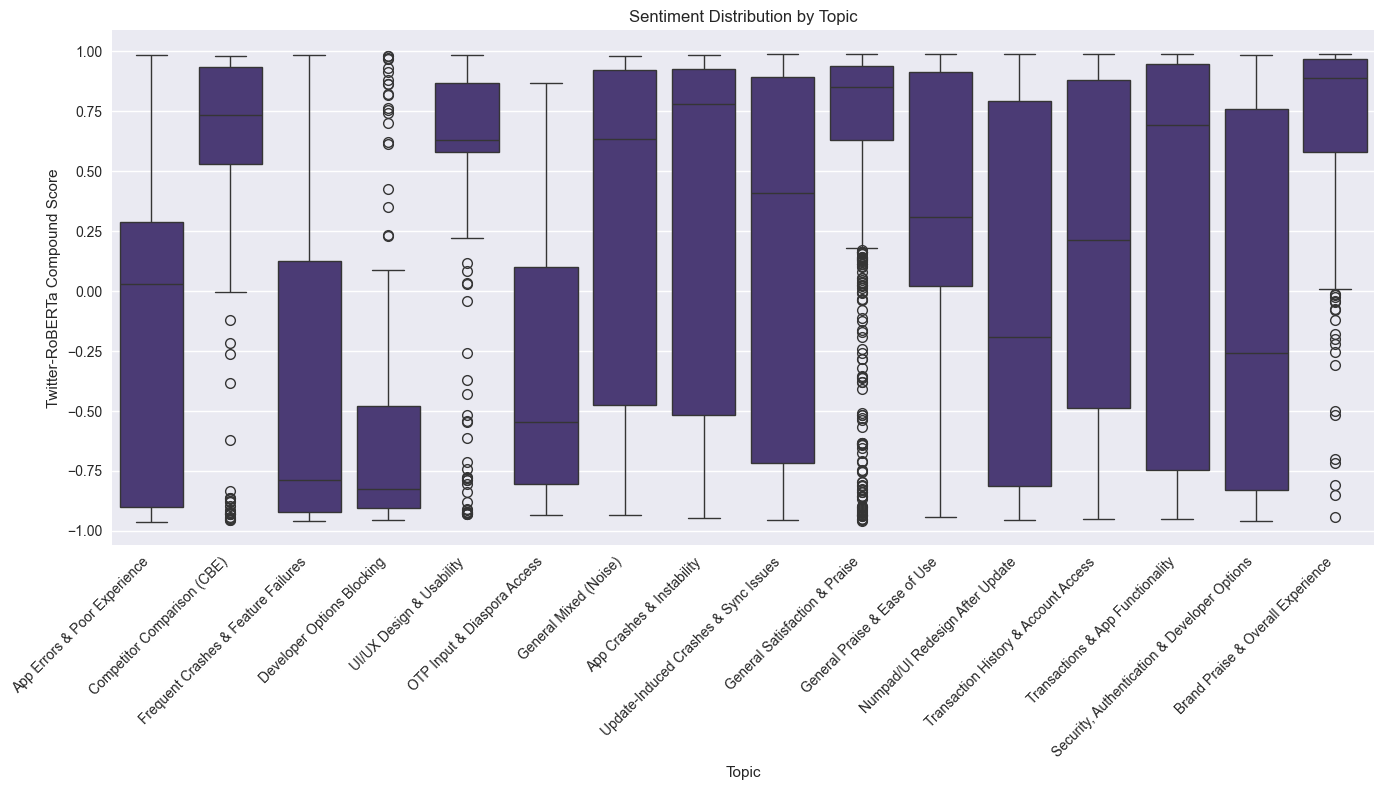

In [19]:
# 7b. Sentiment by topic 
score_col = 'sentiment_score' if 'sentiment_label' in df.columns else None

if score_col:
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df, x='identified_topic', y=score_col)
    plt.title('Sentiment Distribution by Topic')
    plt.xlabel('Topic')
    plt.ylabel('Twitter-RoBERTa Compound Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print('No sentiment_score  column found — skipping sentiment-by-topic plot.')

## Interpretation: Sentiment Distribution by Topic
Strongly negative topics (median below 0):


Developer Options Blocking — strongly negative (~-0.5 median), users are angry about this forced restriction
App Errors & Poor Experience — negative median, consistent complaints
OTP Input & Diaspora Access — slightly negative, users frustrated about being locked out
Frequent Crashed and Feature Failures- It is median is at -0.75 and i

Strongly positive topics (median above 0.5):
Competitor Comparison (CBE) — most positive (~0.75 median), Abyssinia users expressing positive feedback for Abyssina to take inspiration from CBE. 
UI/UX Design & Usability — surprisingly positive (~0.85 median), many reviews praise the design even while suggesting improvements
General Satisfaction & Praise (CBE) and General Praise & Ease of Use (CBE) — both ~0.9, confirms strong brand loyalty
Brand Praise & Overall Experience (Dashen) — very positive (~0.75), validates Dashen's super-app positioning

Mixed/wide-spread topics:
Genera; Mixed/Noise
App crashes and instability 
Transactions & App Functionality (Dashen) — wide spread confirms this topic mixes UI praise with transaction complaints
Numpad/UI Redesign After Update (CBE) — notably negative, validating the pin input frustration
